# Install Imports

In [1]:
import sys
!{sys.executable} -m pip install numpy scipy pillow scikit-image matplotlib
# works with python 3.7.3 numpy==1.15.4 scipy==1.5.4 scikit-image==0.16.1

# Import Modules

In [2]:
import numpy as np

import scipy.ndimage as ndimage

from skimage.metrics import structural_similarity as ssim

from PIL import Image

from os.path import join

# Define Metrics

Root Mean Squared Error   
(Wajid, R., Mansoor, A. B., & Pedersen, M. (2014, December). A human perception based performance evaluation of image quality metrics. In International Symposium on Visual Computing (pp. 303-312). Springer, Cham.)
  
Mean Squared Error   
(Wajid, R., Mansoor, A. B., & Pedersen, M. (2014, December). A human perception based performance evaluation of image quality metrics. In International Symposium on Visual Computing (pp. 303-312). Springer, Cham.)
  
Structural Similarity Index   
(Wajid, R., Mansoor, A. B., & Pedersen, M. (2014, December). A human perception based performance evaluation of image quality metrics. In International Symposium on Visual Computing (pp. 303-312). Springer, Cham.)

In [3]:
def rmse(src, dst):
    return np.sqrt(np.mean(np.square(src - dst)))


def mse(src, dst):
    return np.linalg.norm(src - dst)


def metric(src, dst):
    
    rms = rmse(src, dst)
    ms = mse(src, dst)
    sim = ssim(src, dst, multichannel=True)
    
    return rms, ms, sim

# Pooling-based time aware color smoothing



In [4]:
def running_pooling(matrix, neighbors, frames, steps=2, step_at_two=False):
    work_matrix = np.copy(matrix)
    return_matrix = np.copy(matrix)

    # Set step start
    step_idx = 1 if step_at_two else 0
    
    voting_matrix = [[1 if (i < neighbors / 2 and j <= (i + 1 - step_idx) * steps) or (i == int(neighbors / 2)) or (i > neighbors / 2 and j <= (neighbors - i - step_idx) * steps) else 0 for j in range(frames)] for i in range(neighbors)]
    voting_matrix = np.array(voting_matrix).astype('bool')
    
    # Append ones at top and bottom
    work_matrix = np.concatenate((np.ones((int(neighbors / 2), work_matrix.shape[1], work_matrix.shape[2])), work_matrix), axis=0)
    work_matrix = np.concatenate((work_matrix, np.ones((int(neighbors / 2), work_matrix.shape[1], work_matrix.shape[2]))), axis=0)
    
    # Append ones at end
    work_matrix = np.append(work_matrix, np.ones((work_matrix.shape[0], frames - 1, work_matrix.shape[2])), axis=1)
   
    for i in range(work_matrix.shape[1] - frames + 1):
        y_work_matrix = work_matrix[:,i:i + frames]
        for j in range(y_work_matrix.shape[0] - neighbors + 1):
            y_sub_work_matrix = y_work_matrix[j:j + neighbors]
            voted_matrix = y_sub_work_matrix[voting_matrix]
            voted_matrix = voted_matrix[voted_matrix[:,2].argsort()]
            voted_matrix = voted_matrix[voted_matrix[:,1].argsort(kind='mergesort')]
            voted_matrix = voted_matrix[voted_matrix[:,0].argsort(kind='mergesort')]
            value = np.median(voted_matrix, axis=0)
            return_matrix[j, i] = value
    
    return return_matrix

# Gaussian Blur

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html



In [5]:
def running_gaussian(matrix, sigma):
    return_matrix = np.copy(matrix)

    for i in range(im2arr.shape[1]):
        return_matrix[:,i] = ndimage.gaussian_filter(matrix[:,i], sigma=sigma, order=0)
        
    return return_matrix

# Load Spatial Rug

 - Load image data
 - Transform it to numpy array

In [6]:
rugs_path = 'rugs/'
results_path = 'results/'

im = Image.open(rugs_path + 'originalspatialrug.png')
im2arr = np.array(im)
arr2im = Image.fromarray(im2arr)

# TACS Configuration Variations

In [7]:
pooling_config = [
    [9, 9, 2],
    [11, 9, 2],
    [13, 9, 2],
    [15, 9, 2],
    [17, 9, 2],
    
    [9, 15, 2],
    [11, 15, 2],
    [13, 15, 2],
    [15, 15, 2],
    [17, 15, 2],
    
    [9, 17, 2],
    [11, 17, 2],
    [13, 17, 2],
    [15, 17, 2],
    [17, 17, 2],
    
    [9, 9, 9],
    [11, 11, 11],
    [13, 13, 13],
    [15, 15, 15],
    [17, 17, 17]
]

print('Amount of experiments', len(pooling_config))

pooling_results = []

for i, conf in enumerate(pooling_config):
    im2arr_neighbor = np.copy(im2arr)
    im2arr_neighbor = running_pooling(im2arr, conf[0], conf[1], conf[2])
    metric_res = metric(im2arr, im2arr_neighbor)
    
    pooling_results.append([im2arr_neighbor, metric_res, conf])

    print('\rDone with experiment', i + 1, end=' ')

Amount of experiments 20
Done with experiment 20 

# Gaussian Configuration Variations

In [8]:
gaussian_config = [
    (1, 0),
    (2, 0),
    (3, 0),
    (4, 0),
    (5, 0),
    (6, 0),
    (7, 0),
    (8, 0),
    (9, 0)
]

gaussian_results = []

for conf in gaussian_config:
    im2arr_smooth = np.copy(im2arr)
    for i in range(im2arr.shape[1]):
        im2arr_smooth[:,i] = ndimage.gaussian_filter(im2arr[:,i], sigma=conf)
        
    metric_res = metric(im2arr, im2arr_smooth)
    gaussian_results.append([im2arr_smooth, metric_res, conf])

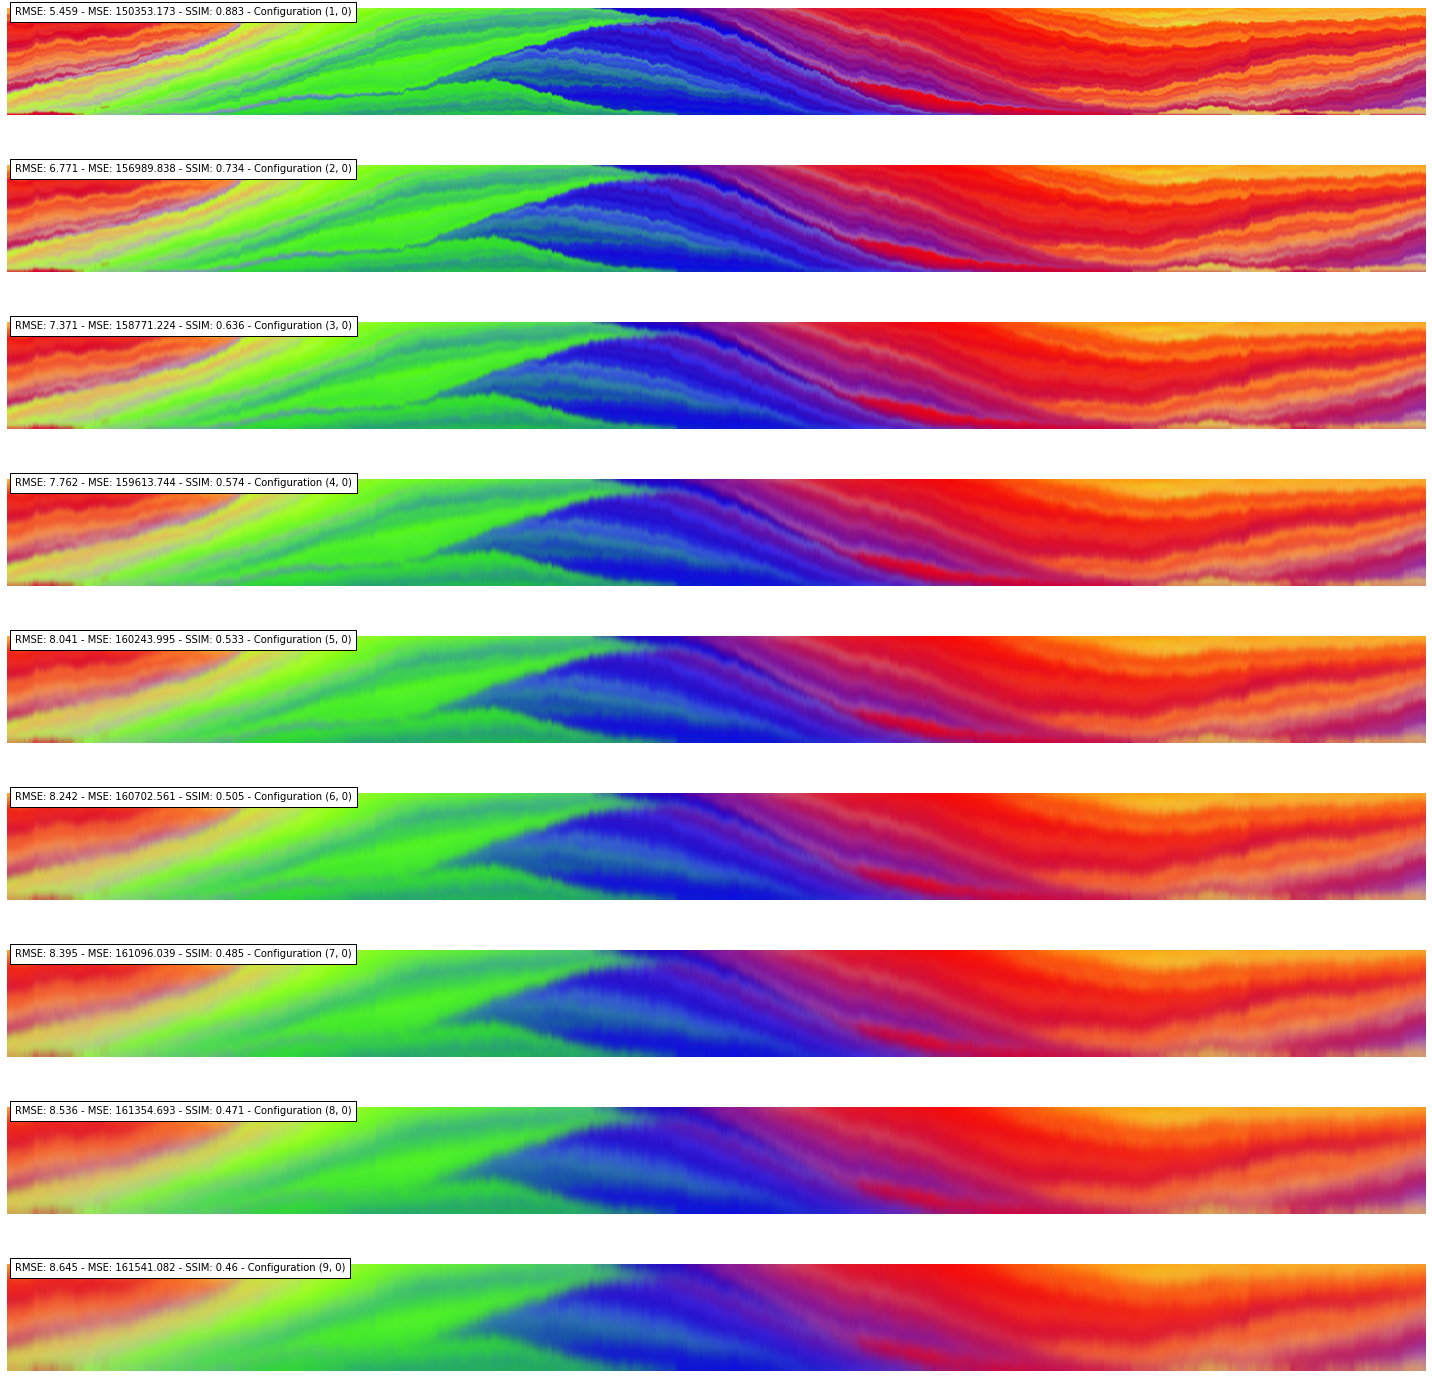

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 20) # (w, h)

fig, axs = plt.subplots(len(gaussian_results), 1)
for i, res in enumerate(gaussian_results):
    axs[i].imshow(res[0], label=str(res[1]) + ' - ' + str(res[2]))
    axs[i].text(10, 10, 'RMSE: ' + str(round(res[1][0], 3)) + ' - MSE: ' + str(round(res[1][1], 3)) + ' - SSIM: ' + str(round(res[1][2], 3)) + ' - Configuration ' + str(res[2]), bbox={'facecolor': 'white', 'pad': 5})
    axs[i].set_axis_off()

fig.tight_layout()
plt.axis('off')
plt.savefig(join(results_path, 'guassian-results.png'))

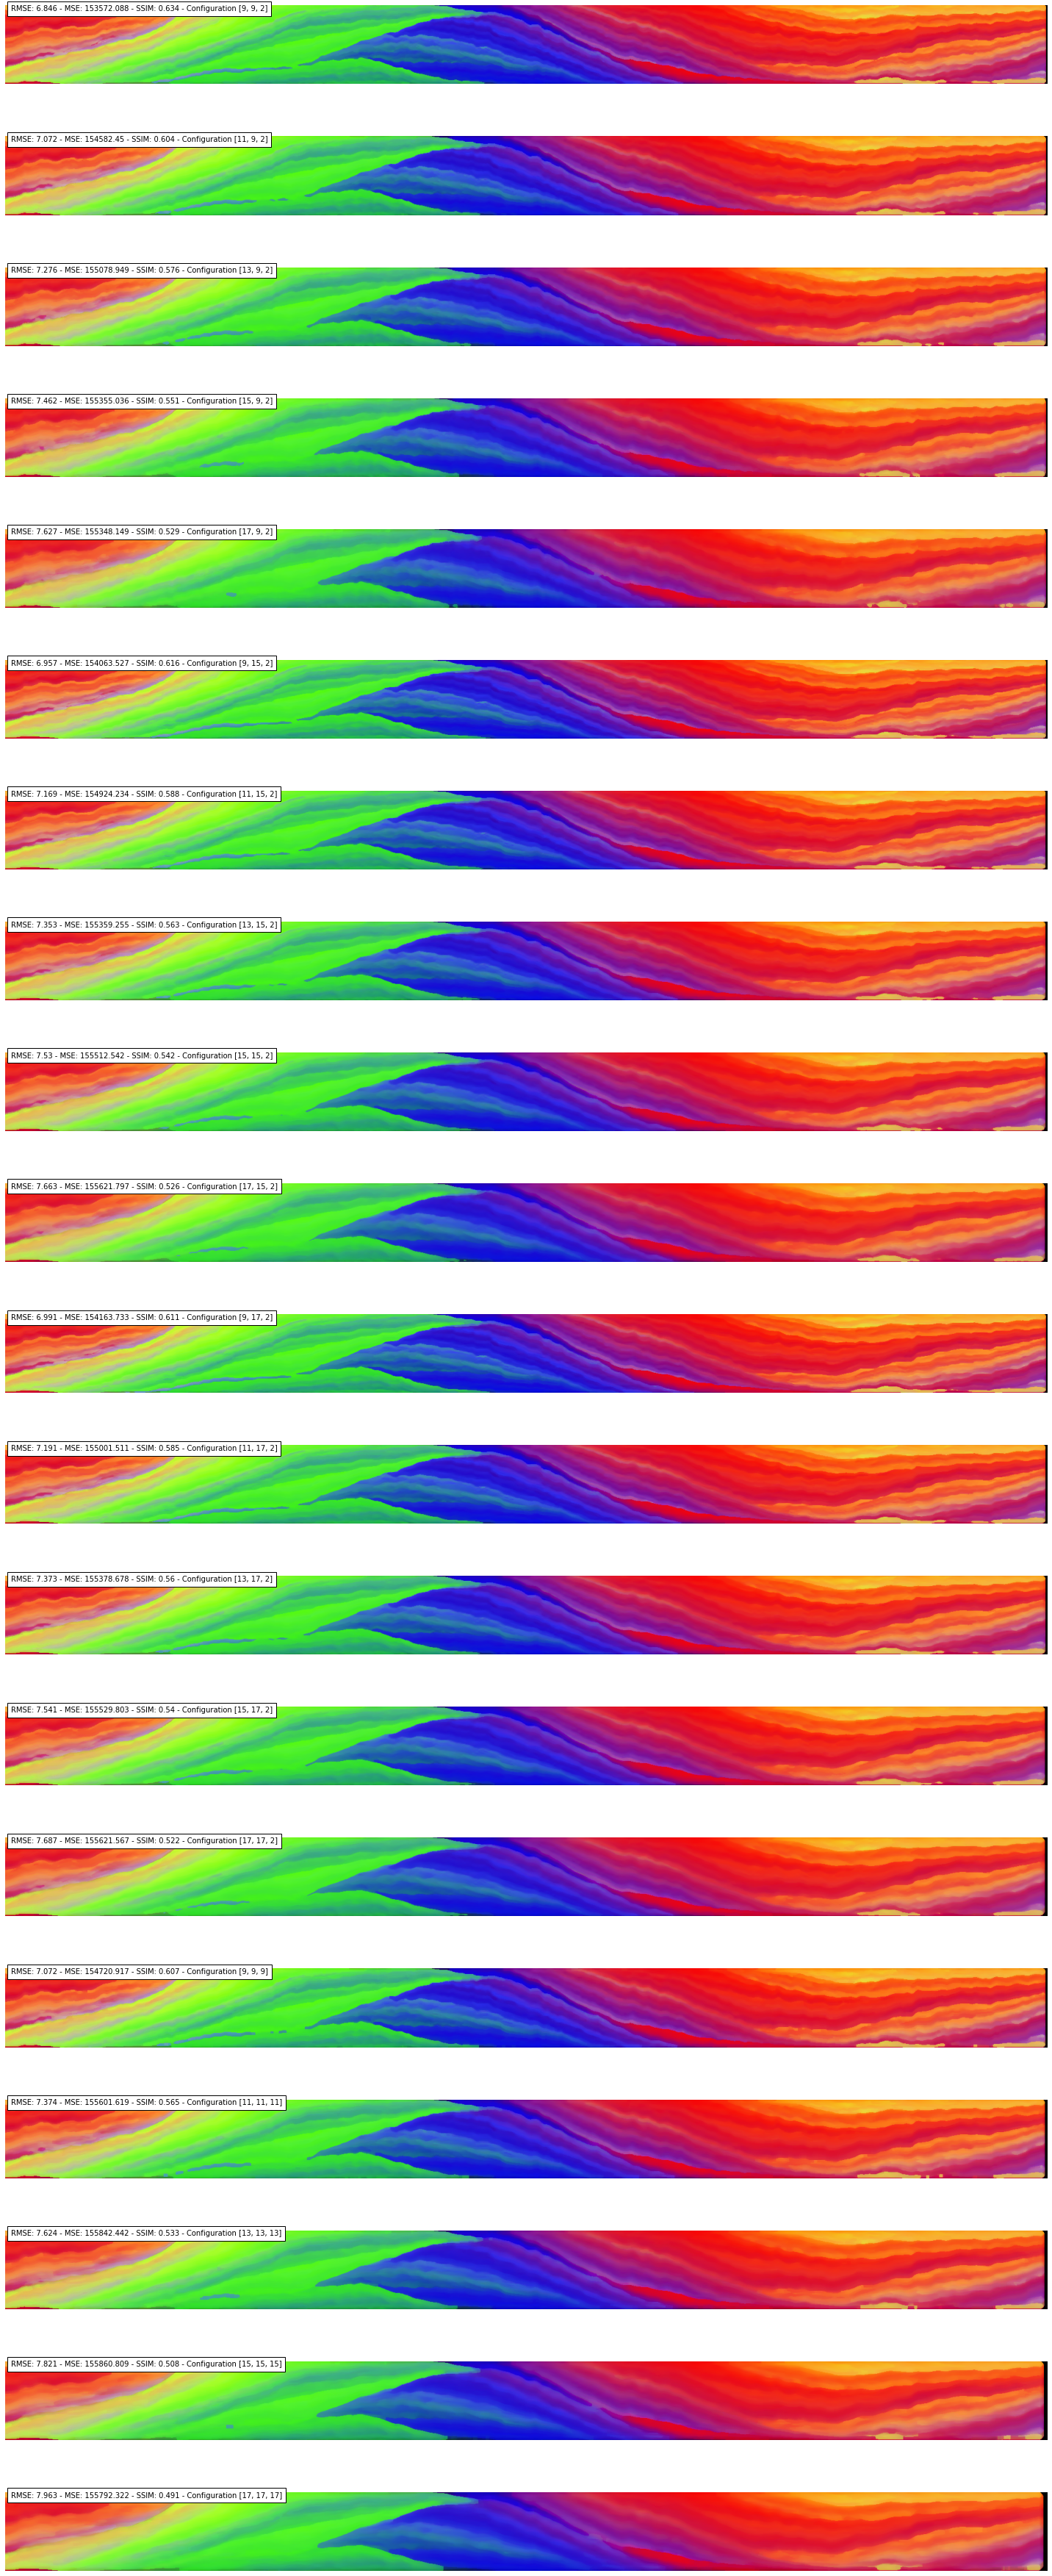

In [10]:
plt.rcParams['figure.figsize'] = (20, 50) # (w, h)

fig, axs = plt.subplots(len(pooling_results), 1)
for i, res in enumerate(pooling_results):
    axs[i].imshow(res[0], label=str(res[1]) + ' - ' + str(res[2]))
    axs[i].text(10, 10, 'RMSE: ' + str(round(res[1][0], 3)) + ' - MSE: ' + str(round(res[1][1], 3)) + ' - SSIM: ' + str(round(res[1][2], 3)) + ' - Configuration ' + str(res[2]), bbox={'facecolor': 'white', 'pad': 5})
    axs[i].set_axis_off()

fig.tight_layout()
plt.axis('off')
plt.savefig(join(results_path, 'tacs-results.png'))

In [11]:
for i, res in enumerate(pooling_results):
    name = 'pooling-'+'-'.join([str(x) for x in res[2]])
    Image.fromarray(res[0]).save(join(results_path, name) + '.png', 'PNG')

In [12]:
for i, res in enumerate(gaussian_results):
    name = 'gaussian-'+'-'.join([str(x) for x in res[2]])
    Image.fromarray(res[0]).save(join(results_path, name) + '.png', 'PNG')

In [13]:
!compare -fuzz 10% -metric mae -verbose -highlight-color red rugs/originalspatialrug.png results/pooling-15-15-2.png results/difference_image.png

/bin/bash: compare: command not found
